In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold

import datetime
import warnings
warnings.filterwarnings("ignore")

# 베이즈 서치 모델

In [2]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [3]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [4]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

In [5]:
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    # 1차 time / 지지
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.date_time.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    # 2차 time / 지지
    train['month_start'] = train.date_time.dt.is_month_start
    train['month_end'] = train.date_time.dt.is_month_end
    
    # 여기까지
    
    #train.drop(['date_time', 'datetime'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [6]:
train = make_time(train)
test = make_time(test)

In [7]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [8]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [9]:
# 6월 6일은 현충일
# 8월 15일은 광복절
# 8월 17일은 임시공휴일

# 휴일이 많지 않으니, 주말에 포함시키자.

train.loc[train.weekday >= 5, 'holiday'] = True
train.loc[train.weekday < 5, 'holiday'] = False
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = True

test.loc[test.weekday >= 5, 'holiday'] = True
test.loc[test.weekday < 5, 'holiday'] = False

train.holiday = train.holiday.astype('bool')
test.holiday = test.holiday.astype('bool')

## Bayes Search of RF: 6.50048

In [18]:
# metric
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

참고: https://wooono.tistory.com/102

학습용 데이터 셋을 먼저 만들어 주고, 테스트용 데이터 셋을 따로 또 만들어 줍니다.

In [12]:
x_train = train.loc[train.date_time < '2020-08-18', ~train.columns.isin(['target', 'date_time'])]
y_train = train.loc[train.date_time < '2020-08-18'][['num', 'target']]
x_test = train.loc[train.date_time >= '2020-08-18', ~train.columns.isin(['target', 'date_time'])]
y_test = train.loc[train.date_time >= '2020-08-18'][['num', 'target']]

In [18]:
#목적함수 생성
def rf_cv(n_estimators):
    
    model = RandomForestRegressor(n_estimators = int(round(n_estimators)),
                                  random_state=42,
                                  n_jobs=-1)
    
    # 모델 훈련
    model.fit(x_train_bo, y_train_bo)

    # 예측값 출력
    y_pred= model.predict(x_test_bo)

    # metric 계산
    smape = SMAPE(y_test_bo, y_pred)

    # 오차 최적화로 사용할 metric 반환
    return -smape

In [19]:
pbounds = {'n_estimators' : (50, 500)}

In [22]:
# 결과물을 적재할 컨테이너를 만듭니다.
preds = []
fe = []
params = []
models = []
targets = []
oob_scores = []

for i in tqdm(range(1, 61)):
    # 베이즈옵트를 위한 train_test set 을 만듭니다.
    x_train_bo = x_train.loc[x_train.num == i, ~x_train.columns.isin(['num', 'cooler', 'solar'])]
    y_train_bo = y_train.loc[y_train.num == i, 'target']
    x_test_bo = x_test.loc[x_test.num == i, ~x_test.columns.isin(['num', 'cooler', 'solar'])]
    y_test_bo = y_test.loc[y_test.num == i, 'target']
    
    # 예측을 위한 train_test set을 만듭니다.
    x_train_building = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar', 'date_time'])]
    y_train_building = train.loc[train.num == i, 'target']
    x_test_building = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar', 'date_time'])]
    
    # 베이즈 옵트를 통해 최적화된 하이퍼 파라미터를 추출합니다.
    bo = BayesianOptimization(f = rf_cv, pbounds = pbounds, verbose = 0, random_state = 0 )
    bo.maximize(init_points=10, n_iter = 20, acq='ei', xi=0.01)
    best_params = bo.max['params']
    best_target = abs(bo.max['target'])
    
    # 하이퍼 파라미터가 소수점으로 되어 있으므로, rounding을 해줍니다.
    for k, v in best_params.items():
        best_params[k] = round(v)
    
    # 최적화된 하이퍼 파라미터로 모델을 생성하고 학습합니다.
    model = RandomForestRegressor(**best_params, oob_score=True ,random_state=42)
    model.fit(x_train_building, y_train_building)
    pred = model.predict(x_test_building)
    
    # 결과물을 적재해줍니다.
    models.append(model)
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    params.append(best_params)
    targets.append(best_target)
    oob_scores.append(model.oob_score_)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [16:14<00:00, 16.25s/it]


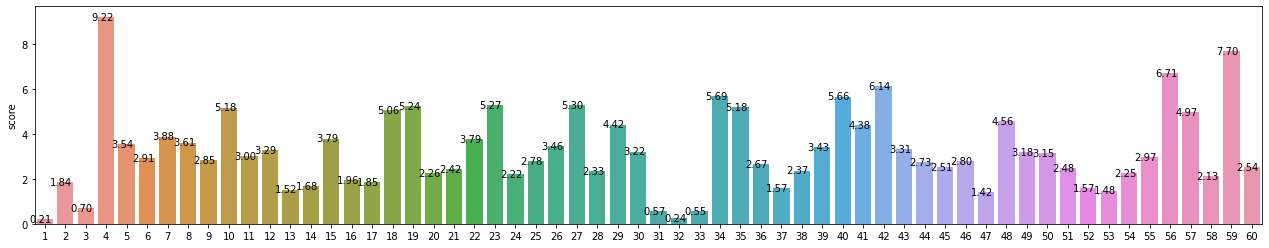

In [23]:
score_df = pd.DataFrame(targets, index=list(range(1, 61)), columns=['score'])
plt.figure(figsize=(22, 4))
plots = sns.barplot(data=score_df, x=score_df.index, y='score')

for bar in plots.patches:
    height = bar.get_height()
    plt.text(bar.get_x()+ 0.25 * bar.get_width(), bar.get_height(),
             '{:.2f}'.format(height),
             ha='center', va='center')
plt.show()

In [24]:
np.sum(oob_scores)

57.155972352232816

In [25]:
preds = sum(preds, [])

In [26]:
sub.answer = preds

In [27]:
sub.to_csv('submission/210611_bo3-rf.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8675.225705
1,1 2020-08-25 01,8672.042361
2,1 2020-08-25 02,8668.667803
3,1 2020-08-25 03,8663.823738
4,1 2020-08-25 04,8655.576787
...,...,...
10075,60 2020-08-31 19,4063.386240
10076,60 2020-08-31 20,4014.581760
10077,60 2020-08-31 21,3796.577280
10078,60 2020-08-31 22,3522.746880


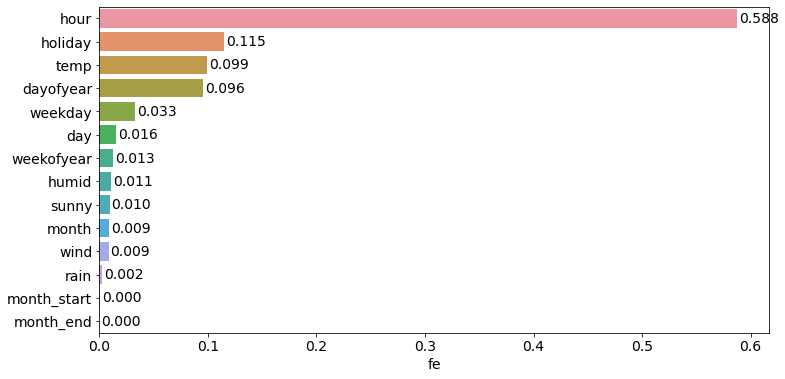

In [28]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=x_train_building.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 6))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.02+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

# 일반 모델

In [10]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')

In [11]:
def make_time(train):
    train['datetime'] = pd.to_datetime(train.date_time)
    
    # 1차 time / 지지
    train['month'] = train.datetime.dt.month                    # 월(숫자)
    train['day'] = train.datetime.dt.day                        # 일(숫자)
    train['hour'] = train.datetime.dt.hour                      # 시(숫자)
    train['weekday'] = train.datetime.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.datetime.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.datetime.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    # 2차 time / 지지
    train['month_start'] = train.datetime.dt.is_month_start
    train['month_end'] = train.datetime.dt.is_month_end
    
    # 여기까지
    
    train.drop(['date_time', 'datetime'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [12]:
train = make_time(train)
test = make_time(test)

In [13]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [14]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [15]:
# 6월 6일은 현충일
# 8월 15일은 광복절
# 8월 17일은 임시공휴일

# 휴일이 많지 않으니, 주말에 포함시키자.

train.loc[train.weekday >= 5, 'holiday'] = True
train.loc[train.weekday < 5, 'holiday'] = False
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = True

test.loc[test.weekday >= 5, 'holiday'] = True
test.loc[test.weekday < 5, 'holiday'] = False

train.holiday = train.holiday.astype('bool')
test.holiday = test.holiday.astype('bool')

In [16]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i,
                                                         ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_building_{}_y'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_building_{}'.format(i)] = test.loc[test.num == i,
                                                       ~test.columns.isin(['num', 'cooler', 'solar'])]

In [17]:
train_building_60.shape, train_building_60_y.shape, test_building_60.shape

((2040, 14), (2040,), (168, 14))

## RF: 6.50285

In [74]:
preds = []
fe = []
oob_scores = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = rf.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(rf.feature_importances_)
    oob_scores.append(rf.oob_score_)
    
np.sum(oob_scores)

100%|████████████████████████████████████████████████████████████████| 60/60 [00:39<00:00,  1.52it/s]


57.189455797322154

In [75]:
rf_preds = sum(preds, [])

In [16]:
sub.answer = preds

In [18]:
#sub.to_csv('submission/210608_537316+holiday.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8670.35016
1,1 2020-08-25 01,8667.75168
2,1 2020-08-25 02,8665.35408
3,1 2020-08-25 03,8658.63432
4,1 2020-08-25 04,8653.11984
...,...,...
10075,60 2020-08-31 19,4064.82624
10076,60 2020-08-31 20,4014.52416
10077,60 2020-08-31 21,3839.38272
10078,60 2020-08-31 22,3520.99440


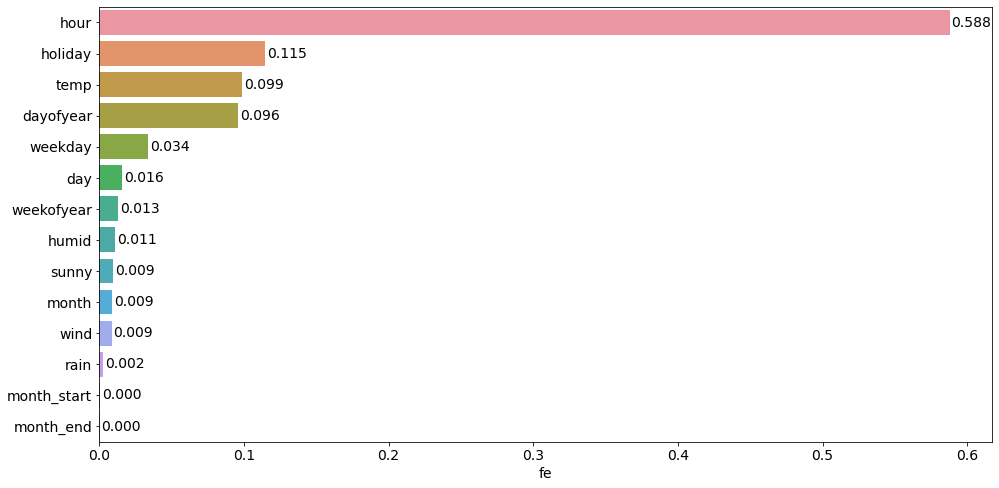

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### RF_noWeekofyear: 6.54862

In [136]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i,
                                                         ~train.columns.isin(['target', 'num',
                                                                              'cooler', 'solar',
                                                                              'weekofyear'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_building_{}_y'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_building_{}'.format(i)] = test.loc[test.num == i,
                                                       ~test.columns.isin(['num', 'cooler', 'solar', 'weekofyear'])]

In [167]:
train_building_60.shape, train_building_60_y.shape, test_building_60.shape

((2040, 13), (2040,), (168, 13))

In [168]:
preds = []
fe = []
oob_scores = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = rf.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(rf.feature_importances_)
    oob_scores.append(rf.oob_score_)
    
np.sum(oob_scores)

100%|████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.61it/s]


57.19088703013956

In [169]:
preds = sum(preds, [])

In [170]:
sub.answer = preds

In [171]:
sub.to_csv('submission/210614_rf-nowoy.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8671.26384
1,1 2020-08-25 01,8669.39112
2,1 2020-08-25 02,8664.82272
3,1 2020-08-25 03,8657.46792
4,1 2020-08-25 04,8651.76552
...,...,...
10075,60 2020-08-31 19,4067.38368
10076,60 2020-08-31 20,4005.90576
10077,60 2020-08-31 21,3824.39664
10078,60 2020-08-31 22,3523.16736


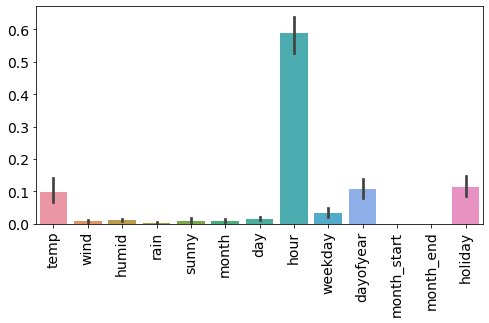

In [165]:
plt.figure(figsize=(8, 4))
sns.barplot(data=fe_avg)
plt.xticks(rotation=90)
plt.show()

### 5-Fold

In [105]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=RandomForestRegressor(random_state=42, oob_score=True)
        model.fit(X_tra, y_tra)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    fe = models[0].feature_importances_ / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
        fe += models[k].feature_importances_ / 5
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
2 번째 모델---------------------------------------------------------------------
3 번째 모델---------------------------------------------------------------------
4 번째 모델---------------------------------------------------------------------
5 번째 모델---------------------------------------------------------------------
6 번째 모델---------------------------------------------------------------------
7 번째 모델---------------------------------------------------------------------
8 번째 모델---------------------------------------------------------------------
9 번째 모델---------------------------------------------------------------------
10 번째 모델---------------------------------------------------------------------
11 번째 모델---------------------------------------------------------------------
12 번째 모델---------------------------------------------------------------------
13 번째 모델-----------------------------------------------------------------

In [106]:
preds = sum(preds, [])

In [107]:
sub.answer = preds

In [108]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.171248
1,1 2020-08-25 01,8676.320832
2,1 2020-08-25 02,8672.016816
3,1 2020-08-25 03,8665.650864
4,1 2020-08-25 04,8657.605296
...,...,...
10075,60 2020-08-31 19,4091.894496
10076,60 2020-08-31 20,4010.398560
10077,60 2020-08-31 21,3804.887520
10078,60 2020-08-31 22,3587.163840


In [109]:
sub.to_csv('submission/210619_rf5fold.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.171248
1,1 2020-08-25 01,8676.320832
2,1 2020-08-25 02,8672.016816
3,1 2020-08-25 03,8665.650864
4,1 2020-08-25 04,8657.605296
...,...,...
10075,60 2020-08-31 19,4091.894496
10076,60 2020-08-31 20,4010.398560
10077,60 2020-08-31 21,3804.887520
10078,60 2020-08-31 22,3587.163840


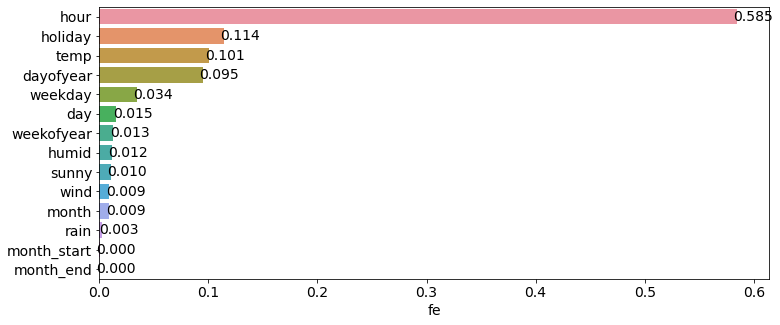

In [110]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 10-Fold

### 15-Fold

### 20-Fold

## Extra Trees: 7.42293

In [80]:
from sklearn.ensemble import ExtraTreesRegressor

In [81]:
preds = []
fe = []
scores = []
for i in tqdm(range(1, 61)):
    et = ExtraTreesRegressor(random_state=42, criterion='mse', n_jobs=-1)
    et.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = et.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(et.feature_importances_)

100%|████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.98it/s]


In [82]:
et_preds = sum(preds, [])

In [185]:
sub.answer = preds

In [27]:
sub.to_csv('submission/210610_537757-with-extratrees.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8677.97712
1,1 2020-08-25 01,8674.68528
2,1 2020-08-25 02,8669.57256
3,1 2020-08-25 03,8658.96480
4,1 2020-08-25 04,8637.66504
...,...,...
10075,60 2020-08-31 19,4174.01424
10076,60 2020-08-31 20,4017.57840
10077,60 2020-08-31 21,3777.42960
10078,60 2020-08-31 22,3608.02512


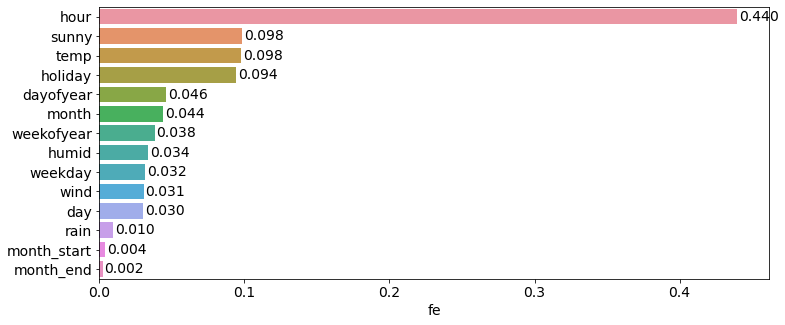

In [187]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### ET-bootstrap: 7.60308

In [48]:
preds = []
fe = []
scores = []
for i in tqdm(range(1, 61)):
    et = ExtraTreesRegressor(random_state=42, bootstrap=True, oob_score=True, criterion='mse', n_jobs=-1)
    et.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = et.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())
    fe.append(et.feature_importances_)
    scores.append(et.oob_score_)

100%|████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.95it/s]


In [49]:
preds = sum(preds, [])

In [50]:
sub.answer = preds

In [51]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8672.59224
1,1 2020-08-25 01,8665.84656
2,1 2020-08-25 02,8663.99976
3,1 2020-08-25 03,8655.43320
4,1 2020-08-25 04,8645.99832
...,...,...
10075,60 2020-08-31 19,4150.65168
10076,60 2020-08-31 20,4023.10800
10077,60 2020-08-31 21,3779.68896
10078,60 2020-08-31 22,3614.50080


In [73]:
sub.to_csv('submission/210618_extratrees-with-bootstrap.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8672.59224
1,1 2020-08-25 01,8665.84656
2,1 2020-08-25 02,8663.99976
3,1 2020-08-25 03,8655.43320
4,1 2020-08-25 04,8645.99832
...,...,...
10075,60 2020-08-31 19,4150.65168
10076,60 2020-08-31 20,4023.10800
10077,60 2020-08-31 21,3779.68896
10078,60 2020-08-31 22,3614.50080


## XGB: 6.39996

In [86]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_x_{}'.format(i)] = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_y_{}'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_x_{}'.format(i)] = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar'])]

In [76]:
preds = []
fe = []
for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=XGBRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='rmse',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)

1 번째 모델---------------------------------------------------------------------
[0]	validation_0-rmse:8313.51367	validation_1-rmse:8312.31055
[612]	validation_0-rmse:9.84939	validation_1-rmse:24.96095
[0]	validation_0-rmse:8313.42188	validation_1-rmse:8312.69727
[1137]	validation_0-rmse:5.20775	validation_1-rmse:21.43129
[0]	validation_0-rmse:8313.57519	validation_1-rmse:8312.05762
[554]	validation_0-rmse:10.11942	validation_1-rmse:42.12930
[0]	validation_0-rmse:8314.43262	validation_1-rmse:8308.50586
[431]	validation_0-rmse:11.94860	validation_1-rmse:32.83336
[0]	validation_0-rmse:8311.45606	validation_1-rmse:8320.82422
[526]	validation_0-rmse:10.74503	validation_1-rmse:23.19531
2 번째 모델---------------------------------------------------------------------
[0]	validation_0-rmse:1305.49841	validation_1-rmse:1310.21362
[907]	validation_0-rmse:10.29714	validation_1-rmse:31.09786
[0]	validation_0-rmse:1311.93994	validation_1-rmse:1283.84888
[551]	validation_0-rmse:15.39724	validation_1-rmse:34

In [77]:
xgb_preds = sum(preds, [])

In [99]:
sub.answer = xgb_preds

In [101]:
sub.to_csv('submission/210615_538867-with-10000estimators.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8679.394531
1,1 2020-08-25 01,8656.399414
2,1 2020-08-25 02,8642.821289
3,1 2020-08-25 03,8633.095703
4,1 2020-08-25 04,8623.215820
...,...,...
10075,60 2020-08-31 19,4059.909668
10076,60 2020-08-31 20,3951.680664
10077,60 2020-08-31 21,3808.103271
10078,60 2020-08-31 22,3685.906982


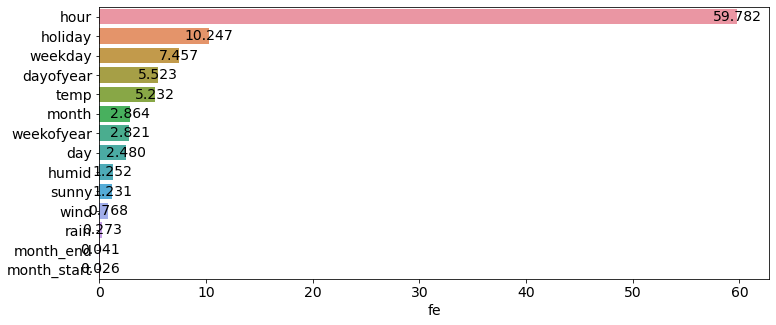

In [102]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## LGBM: 6.34797 -> 538870

In [18]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_x_{}'.format(i)] = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_y_{}'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_x_{}'.format(i)] = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar'])]

In [78]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    fe = models[0].feature_importances_ / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
        fe += models[k].feature_importances_ / 5
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[816]	training's l2: 214.164	valid_1's l2: 522.316
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1076]	training's l2: 160.004	valid_1's l2: 491.517
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[734]	training's l2: 85.2974	valid_1's l2: 1737.04
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[417]	training's l2: 327.956	valid_1's l2: 744.058
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[591]	training's l2: 258.02	valid_1's l2: 561.382
2 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[535]	training'

In [79]:
lgbm_preds = sum(preds, [])

In [191]:
sub.answer = preds

In [192]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.808249
1,1 2020-08-25 01,8667.287999
2,1 2020-08-25 02,8653.053657
3,1 2020-08-25 03,8640.719860
4,1 2020-08-25 04,8634.266314
...,...,...
10075,60 2020-08-31 19,4036.639616
10076,60 2020-08-31 20,3930.032691
10077,60 2020-08-31 21,3796.872690
10078,60 2020-08-31 22,3613.909907


In [50]:
sub.to_csv('submission/210612_537757-with-lgbm.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8679.823112
1,1 2020-08-25 01,8666.608097
2,1 2020-08-25 02,8653.262284
3,1 2020-08-25 03,8640.817195
4,1 2020-08-25 04,8634.318897
...,...,...
10075,60 2020-08-31 19,4036.639616
10076,60 2020-08-31 20,3930.032691
10077,60 2020-08-31 21,3796.872690
10078,60 2020-08-31 22,3613.909907


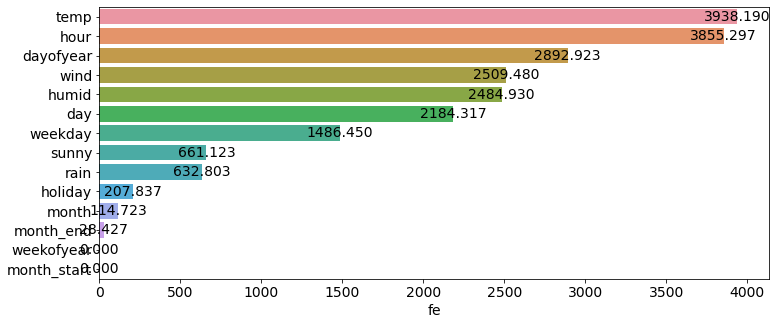

In [193]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 538870+es30: 6.343637 -> 539437

In [196]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    fe = models[0].feature_importances_ / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
        fe += models[k].feature_importances_ / 5
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[816]	training's l2: 214.164	valid_1's l2: 522.316
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1076]	training's l2: 160.004	valid_1's l2: 491.517
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[734]	training's l2: 85.2974	valid_1's l2: 1737.04
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[417]	training's l2: 327.956	valid_1's l2: 744.058
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[591]	training's l2: 258.02	valid_1's l2: 561.382
2 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[535]	training'

In [197]:
preds = sum(preds, [])

In [198]:
sub.answer = preds

In [200]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.808249
1,1 2020-08-25 01,8667.287999
2,1 2020-08-25 02,8653.053657
3,1 2020-08-25 03,8640.719860
4,1 2020-08-25 04,8634.266314
...,...,...
10075,60 2020-08-31 19,4036.639616
10076,60 2020-08-31 20,3930.032691
10077,60 2020-08-31 21,3796.872690
10078,60 2020-08-31 22,3613.909907


In [202]:
sub.to_csv('submission/210614_537757-with-lgbm-es30.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.808249
1,1 2020-08-25 01,8667.287999
2,1 2020-08-25 02,8653.053657
3,1 2020-08-25 03,8640.719860
4,1 2020-08-25 04,8634.266314
...,...,...
10075,60 2020-08-31 19,4036.639616
10076,60 2020-08-31 20,3930.032691
10077,60 2020-08-31 21,3796.872690
10078,60 2020-08-31 22,3613.909907


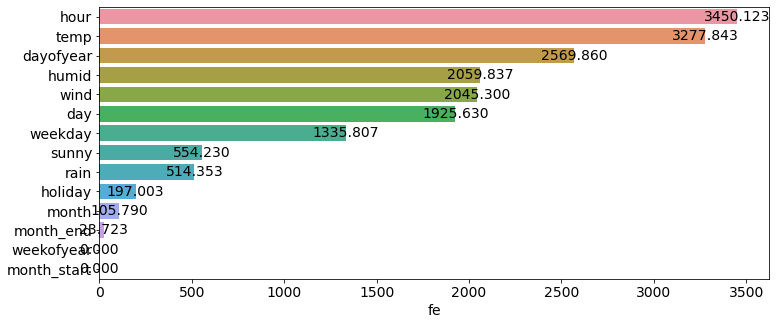

In [116]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 538870+catfeatures: 6.56811

In [117]:
train_x_1.head()

,temp,wind,humid,rain,sunny,month,day,hour,weekday,dayofyear,weekofyear,month_start,month_end,holiday
0,17.6,2.5,92.0,0.8,0.0,6,1,0,0,153,23,True,False,False
1,17.7,2.9,91.0,0.3,0.0,6,1,1,0,153,23,True,False,False
2,17.5,3.2,91.0,0.0,0.0,6,1,2,0,153,23,True,False,False
3,17.1,3.2,91.0,0.0,0.0,6,1,3,0,153,23,True,False,False
4,17.0,3.3,92.0,0.0,0.0,6,1,4,0,153,23,True,False,False


In [118]:
cat_features = [5, 7, 8, 11, 12, 13]

In [119]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape', categorical_feature=cat_features,
                  early_stopping_rounds=20, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    fe = models[0].feature_importances_ / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
        fe += models[k].feature_importances_ / 5
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[417]	training's l2: 288.683	valid_1's l2: 822.579
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[518]	training's l2: 228.592	valid_1's l2: 600.625
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[491]	training's l2: 110.149	valid_1's l2: 1984.39
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[483]	training's l2: 233.261	valid_1's l2: 825.861
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[299]	training's l2: 366.323	valid_1's l2: 764.008
2 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[538]	training'

In [120]:
preds = sum(preds, [])

In [121]:
sub.answer = preds

In [122]:
sub.to_csv('submission/210613_538870-lgbm-catfeatures.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8685.968057
1,1 2020-08-25 01,8682.791964
2,1 2020-08-25 02,8659.228674
3,1 2020-08-25 03,8649.534001
4,1 2020-08-25 04,8639.779094
...,...,...
10075,60 2020-08-31 19,4031.471218
10076,60 2020-08-31 20,3953.275757
10077,60 2020-08-31 21,3828.493122
10078,60 2020-08-31 22,3588.514695


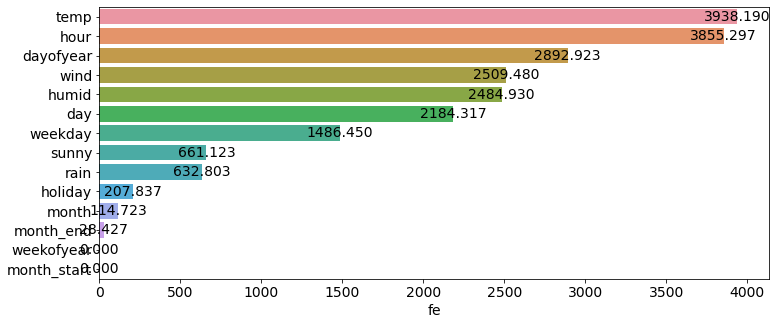

In [194]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 539437+goss: 6.52731

In [28]:
train_x_1.head()

,temp,wind,humid,rain,sunny,month,day,hour,weekday,dayofyear,weekofyear,month_start,month_end,holiday
0,17.6,2.5,92.0,0.8,0.0,6,1,0,0,153,23,True,False,False
1,17.7,2.9,91.0,0.3,0.0,6,1,1,0,153,23,True,False,False
2,17.5,3.2,91.0,0.0,0.0,6,1,2,0,153,23,True,False,False
3,17.1,3.2,91.0,0.0,0.0,6,1,3,0,153,23,True,False,False
4,17.0,3.3,92.0,0.0,0.0,6,1,4,0,153,23,True,False,False


In [92]:
params = {'learning_rate': 0.027,
         'random_state': 42,
         'n_estimators': 10000,
         'n_jobs': -1,
         'boosting_type': 'goss'}

In [93]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(**params)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    fe = models[0].feature_importances_ / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
        fe += models[k].feature_importances_ / 5
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[872]	training's l2: 363.679	valid_1's l2: 525.727
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[954]	training's l2: 324.651	valid_1's l2: 501.506
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[847]	training's l2: 183.631	valid_1's l2: 1900.22
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[604]	training's l2: 439.727	valid_1's l2: 694.856
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[492]	training's l2: 493.446	valid_1's l2: 616.827
2 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[897]	training'

In [94]:
goss_preds = sum(preds, [])

In [41]:
sub.answer = preds

In [43]:
sub.to_csv('submission/210614_539437-with-lgbm-goss.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8667.844810
1,1 2020-08-25 01,8651.536956
2,1 2020-08-25 02,8641.489469
3,1 2020-08-25 03,8632.532798
4,1 2020-08-25 04,8623.866767
...,...,...
10075,60 2020-08-31 19,4034.643044
10076,60 2020-08-31 20,3938.731043
10077,60 2020-08-31 21,3797.716975
10078,60 2020-08-31 22,3624.768295


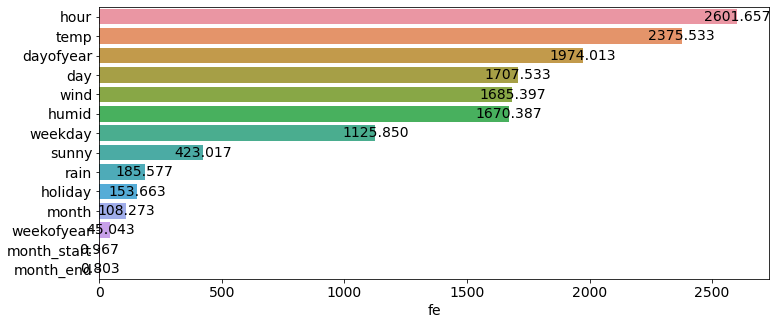

In [44]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### dart: 6.38134

In [28]:
train_x_1.head()

,temp,wind,humid,rain,sunny,month,day,hour,weekday,dayofyear,weekofyear,month_start,month_end,holiday
0,17.6,2.5,92.0,0.8,0.0,6,1,0,0,153,23,True,False,False
1,17.7,2.9,91.0,0.3,0.0,6,1,1,0,153,23,True,False,False
2,17.5,3.2,91.0,0.0,0.0,6,1,2,0,153,23,True,False,False
3,17.1,3.2,91.0,0.0,0.0,6,1,3,0,153,23,True,False,False
4,17.0,3.3,92.0,0.0,0.0,6,1,4,0,153,23,True,False,False


In [52]:
params = {'learning_rate': 0.027,
         'random_state': 42,
         'n_estimators': 20000,
         'n_jobs': -1,
         'boosting_type': 'dart'}

In [ ]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(**params)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=100)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    fe = models[0].feature_importances_ / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
        fe += models[k].feature_importances_ / 5
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
[100]	training's l2: 6.43627e+06	valid_1's l2: 6.42832e+06
[200]	training's l2: 6.55985e+06	valid_1's l2: 6.55159e+06
[300]	training's l2: 2.39209e+06	valid_1's l2: 2.38708e+06
[400]	training's l2: 1.97634e+06	valid_1's l2: 1.97162e+06
[500]	training's l2: 1.04562e+06	valid_1's l2: 1.04212e+06
[600]	training's l2: 842706	valid_1's l2: 839551
[700]	training's l2: 377979	valid_1's l2: 375877
[800]	training's l2: 237730	valid_1's l2: 236190
[900]	training's l2: 177695	valid_1's l2: 176482
[1000]	training's l2: 201256	valid_1's l2: 200092
[1100]	training's l2: 64957.6	valid_1's l2: 64372.2
[1200]	training's l2: 154739	valid_1's l2: 153746
[1300]	training's l2: 130710	valid_1's l2: 129860
[1400]	training's l2: 65141.6	valid_1's l2: 64614.3
[1500]	training's l2: 88768.7	valid_1's l2: 88125.6
[1600]	training's l2: 35184.2	valid_1's l2: 34832.5
[1700]	training's l2: 51074.1	valid_1's l2: 50614.7
[1800]	training's l2: 

In [ ]:
preds = sum(preds, [])

In [ ]:
sub.answer = preds

In [57]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8668.859940
1,1 2020-08-25 01,8651.694767
2,1 2020-08-25 02,8645.116036
3,1 2020-08-25 03,8632.837937
4,1 2020-08-25 04,8627.343291
...,...,...
10075,60 2020-08-31 19,4145.561418
10076,60 2020-08-31 20,4024.808470
10077,60 2020-08-31 21,3881.168956
10078,60 2020-08-31 22,3706.081904


In [60]:
sub.to_csv('submission/210615_539437-with-lgbm-dart.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8668.859940
1,1 2020-08-25 01,8651.694767
2,1 2020-08-25 02,8645.116036
3,1 2020-08-25 03,8632.837937
4,1 2020-08-25 04,8627.343291
...,...,...
10075,60 2020-08-31 19,4145.561418
10076,60 2020-08-31 20,4024.808470
10077,60 2020-08-31 21,3881.168956
10078,60 2020-08-31 22,3706.081904


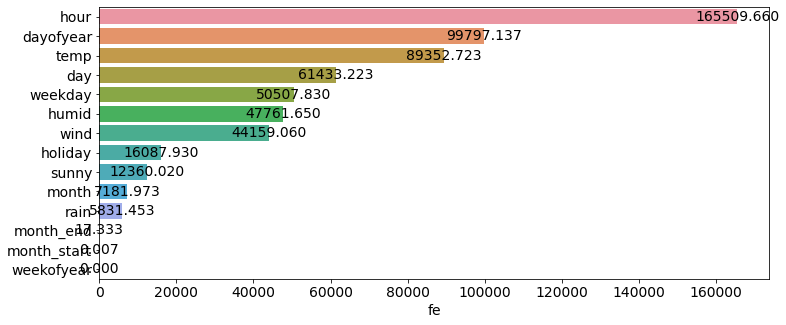

In [59]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 10-Fold: 6.40203

In [19]:
FOLD = 10

In [26]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(FOLD):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / FOLD
    fe = models[0].feature_importances_ / FOLD
    for k in range(1, FOLD):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / FOLD
        fe += models[k].feature_importances_ / FOLD
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[461]	training's l2: 306.151	valid_1's l2: 515.487
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[777]	training's l2: 209.915	valid_1's l2: 430.975
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1367]	training's l2: 119.21	valid_1's l2: 395.47
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[622]	training's l2: 234.956	valid_1's l2: 701.65
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[247]	training's l2: 333.41	valid_1's l2: 1708.6
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1836]	training's l2: 59.7191	valid_1's l2: 1704.88
Training until validation scores don't impro

In [27]:
lgbm_preds = sum(preds, [])

In [28]:
sub.answer = lgbm_preds

In [29]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8681.786750
1,1 2020-08-25 01,8667.242131
2,1 2020-08-25 02,8651.623564
3,1 2020-08-25 03,8641.132957
4,1 2020-08-25 04,8635.737240
...,...,...
10075,60 2020-08-31 19,4048.706047
10076,60 2020-08-31 20,3951.155443
10077,60 2020-08-31 21,3802.439854
10078,60 2020-08-31 22,3623.270287


In [30]:
sub.to_csv('submission/210618_539437-with-10fold.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8681.786750
1,1 2020-08-25 01,8667.242131
2,1 2020-08-25 02,8651.623564
3,1 2020-08-25 03,8641.132957
4,1 2020-08-25 04,8635.737240
...,...,...
10075,60 2020-08-31 19,4048.706047
10076,60 2020-08-31 20,3951.155443
10077,60 2020-08-31 21,3802.439854
10078,60 2020-08-31 22,3623.270287


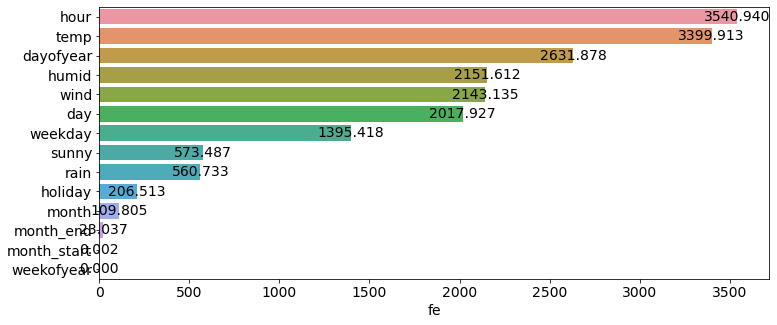

In [31]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 15-Fold: 6.39613

In [38]:
FOLD = 15

In [39]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(FOLD):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / FOLD
    fe = models[0].feature_importances_ / FOLD
    for k in range(1, FOLD):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / FOLD
        fe += models[k].feature_importances_ / FOLD
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[271]	training's l2: 407.648	valid_1's l2: 495.832
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1385]	training's l2: 116.677	valid_1's l2: 343.914
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[730]	training's l2: 215.292	valid_1's l2: 557.929
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[546]	training's l2: 257.171	valid_1's l2: 424.145
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[633]	training's l2: 239.389	valid_1's l2: 360.407
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[478]	training's l2: 279.319	valid_1's l2: 900.656
Training until validation scores don't i

In [40]:
preds = sum(preds, [])

In [41]:
sub.answer = preds

In [42]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8682.962116
1,1 2020-08-25 01,8667.992686
2,1 2020-08-25 02,8652.134566
3,1 2020-08-25 03,8641.529018
4,1 2020-08-25 04,8634.924977
...,...,...
10075,60 2020-08-31 19,4048.862084
10076,60 2020-08-31 20,3946.581174
10077,60 2020-08-31 21,3807.894470
10078,60 2020-08-31 22,3622.338209


In [43]:
sub.to_csv('submission/210618_539437-with-15fold.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8682.962116
1,1 2020-08-25 01,8667.992686
2,1 2020-08-25 02,8652.134566
3,1 2020-08-25 03,8641.529018
4,1 2020-08-25 04,8634.924977
...,...,...
10075,60 2020-08-31 19,4048.862084
10076,60 2020-08-31 20,3946.581174
10077,60 2020-08-31 21,3807.894470
10078,60 2020-08-31 22,3622.338209


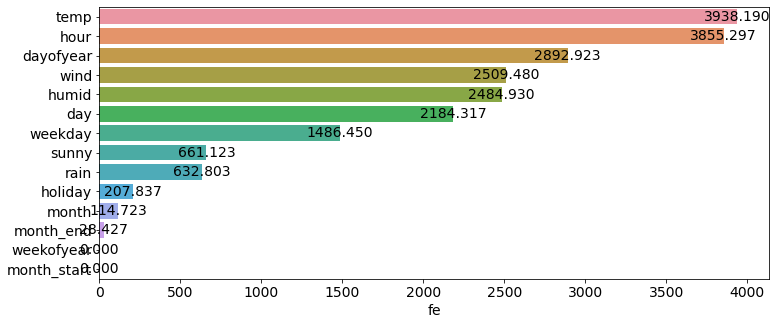

In [193]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### 20-Fold

In [19]:
FOLD = 20

In [ ]:
preds = []
fes = []

for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=FOLD, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(FOLD):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=10000)
        models[fold]=model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / FOLD
    fe = models[0].feature_importances_ / FOLD
    for k in range(1, FOLD):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / FOLD
        fe += models[k].feature_importances_ / FOLD
    
    preds.append(pred.tolist())
    fes.append(fe)

1 번째 모델---------------------------------------------------------------------
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[461]	training's l2: 306.151	valid_1's l2: 515.487
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[777]	training's l2: 209.915	valid_1's l2: 430.975
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1367]	training's l2: 119.21	valid_1's l2: 395.47
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[622]	training's l2: 234.956	valid_1's l2: 701.65
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[247]	training's l2: 333.41	valid_1's l2: 1708.6
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1836]	training's l2: 59.7191	valid_1's l2: 1704.88
Training until validation scores don't impro

In [91]:
lgbm_preds = sum(preds, [])

In [191]:
sub.answer = preds

In [192]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.808249
1,1 2020-08-25 01,8667.287999
2,1 2020-08-25 02,8653.053657
3,1 2020-08-25 03,8640.719860
4,1 2020-08-25 04,8634.266314
...,...,...
10075,60 2020-08-31 19,4036.639616
10076,60 2020-08-31 20,3930.032691
10077,60 2020-08-31 21,3796.872690
10078,60 2020-08-31 22,3613.909907


In [50]:
sub.to_csv('submission/210612_537757-with-lgbm.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8679.823112
1,1 2020-08-25 01,8666.608097
2,1 2020-08-25 02,8653.262284
3,1 2020-08-25 03,8640.817195
4,1 2020-08-25 04,8634.318897
...,...,...
10075,60 2020-08-31 19,4036.639616
10076,60 2020-08-31 20,3930.032691
10077,60 2020-08-31 21,3796.872690
10078,60 2020-08-31 22,3613.909907


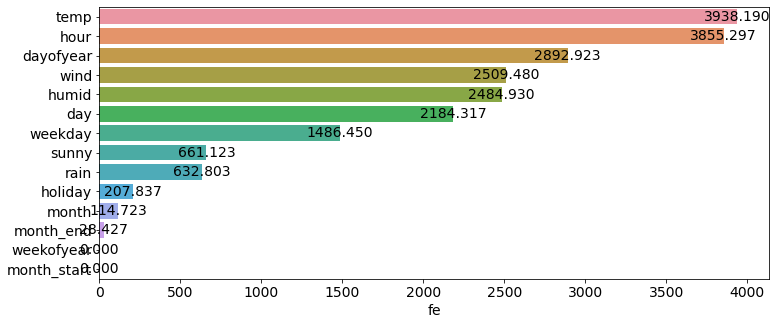

In [193]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fes, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

## CATB: 6.96521(noCatFeatures)

In [95]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_x_{}'.format(i)] = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_y_{}'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_x_{}'.format(i)] = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar'])]

In [80]:
now = datetime.datetime.now()
print(now)

preds = []
fe = []
for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model = CatBoostRegressor(learning_rate=0.027, random_state=42, n_estimators=10000, eval_metric='SMAPE')
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  early_stopping_rounds=30, verbose=10000)
        models[fold] = model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    
now = datetime.datetime.now()
print(now)

2021-06-18 16:06:28.519550
1 번째 모델---------------------------------------------------------------------
0:	learn: 1.0142462	test: 1.0142462	test1: 0.9834769	best: 0.9834769 (0)	total: 143ms	remaining: 23m 50s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1800127879
bestIteration = 2340

Shrink model to first 2341 iterations.
0:	learn: 1.0203394	test: 1.0203394	test1: 0.9586767	best: 0.9586767 (0)	total: 1.39ms	remaining: 13.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1822085448
bestIteration = 2361

Shrink model to first 2362 iterations.
0:	learn: 0.9936644	test: 0.9936644	test1: 1.0646301	best: 1.0646301 (0)	total: 1.4ms	remaining: 14s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2081038762
bestIteration = 2168

Shrink model to first 2169 iterations.
0:	learn: 1.0053720	test: 1.0053720	test1: 1.0125864	best: 1.0125864 (0)	total: 17ms	remaining: 2m 49s
Stopped by overfitting detector  (30 iterations wait)

bestTest

In [81]:
cat_preds = sum(preds, [])

### cat_features = [5, 7, 8, 11, 12, 13]: 7.25982

In [13]:
cat_features = [5, 7, 8, 11, 12, 13]

In [66]:
now = datetime.datetime.now()
print(now)

preds = []
fe = []
for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model = CatBoostRegressor(learning_rate=0.027, random_state=42, n_estimators=10000, eval_metric='SMAPE')
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  cat_features=cat_features,
                  early_stopping_rounds=20, verbose=10000)
        models[fold] = model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    
now = datetime.datetime.now()
print(now)

2021-06-12 01:57:36.679950
1 번째 모델---------------------------------------------------------------------
0:	learn: 127.6721071	test: 127.6721071	test1: 129.0152224	best: 129.0152224 (0)	total: 49.3ms	remaining: 8m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 23.78823678
bestIteration = 2279

Shrink model to first 2280 iterations.
0:	learn: 130.2973389	test: 130.2973389	test1: 118.0028987	best: 118.0028987 (0)	total: 24.8ms	remaining: 4m 7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 26.4776705
bestIteration = 1559

Shrink model to first 1560 iterations.
0:	learn: 125.8814936	test: 125.8814936	test1: 135.7292478	best: 135.7292478 (0)	total: 56.9ms	remaining: 9m 28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 44.20149541
bestIteration = 1135

Shrink model to first 1136 iterations.
0:	learn: 127.2192292	test: 127.2192292	test1: 130.6258744	best: 130.6258744 (0)	total: 34.8ms	remaining: 5m 48s
Stopped by overfitting detect

너무 오래 걸린다. 8시간이 실화냐

In [67]:
preds = sum(preds, [])

In [68]:
sub.answer = preds

In [70]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8675.085370
1,1 2020-08-25 01,8658.213903
2,1 2020-08-25 02,8649.360392
3,1 2020-08-25 03,8629.619511
4,1 2020-08-25 04,8620.730656
...,...,...
10075,60 2020-08-31 19,4044.200073
10076,60 2020-08-31 20,3928.848304
10077,60 2020-08-31 21,3824.677863
10078,60 2020-08-31 22,3614.251417


In [71]:
sub.to_csv('submission/210612_537757-with-catb-catfeatures.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8675.085370
1,1 2020-08-25 01,8658.213903
2,1 2020-08-25 02,8649.360392
3,1 2020-08-25 03,8629.619511
4,1 2020-08-25 04,8620.730656
...,...,...
10075,60 2020-08-31 19,4044.200073
10076,60 2020-08-31 20,3928.848304
10077,60 2020-08-31 21,3824.677863
10078,60 2020-08-31 22,3614.251417


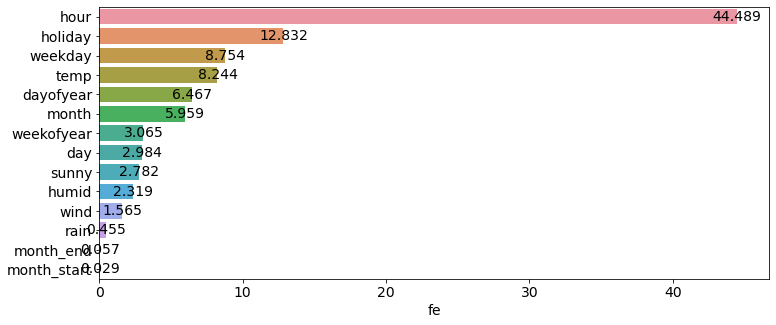

In [72]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

### cat_features = [5, 8, 11, 12, 13]

In [36]:
train_x_1.head(3)

,temp,wind,humid,rain,sunny,month,day,hour,weekday,dayofyear,weekofyear,month_start,month_end,holiday
0,17.6,2.5,92.0,0.8,0.0,6,1,0,0,153,23,True,False,False
1,17.7,2.9,91.0,0.3,0.0,6,1,1,0,153,23,True,False,False
2,17.5,3.2,91.0,0.0,0.0,6,1,2,0,153,23,True,False,False


In [37]:
cat_features = [5, 8, 11, 12, 13]

In [38]:
now = datetime.datetime.now()
print(now)

preds = []
fe = []
for i in range(1, 61):
    print(i, '번째 모델---------------------------------------------------------------------')    
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model = CatBoostRegressor(learning_rate=0.027, random_state=42, n_estimators=10000, eval_metric='SMAPE')
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  cat_features=cat_features,
                  early_stopping_rounds=20, verbose=10000)
        models[fold] = model
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    
    preds.append(pred.tolist())
    fe.append(model.feature_importances_)
    
now = datetime.datetime.now()
print(now)

2021-06-12 22:53:43.837025
1 번째 모델---------------------------------------------------------------------
0:	learn: 1.0162849	test: 1.0162849	test1: 0.9849844	best: 0.9849844 (0)	total: 163ms	remaining: 27m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1882629175
bestIteration = 1458

Shrink model to first 1459 iterations.
0:	learn: 1.0229141	test: 1.0229141	test1: 0.9607566	best: 0.9607566 (0)	total: 33.9ms	remaining: 5m 39s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1891442829
bestIteration = 1518

Shrink model to first 1519 iterations.
0:	learn: 0.9952902	test: 0.9952902	test1: 1.0680452	best: 1.0680452 (0)	total: 38.4ms	remaining: 6m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2141606238
bestIteration = 2366

Shrink model to first 2367 iterations.
0:	learn: 1.0085138	test: 1.0085138	test1: 1.0151074	best: 1.0151074 (0)	total: 39.5ms	remaining: 6m 35s
Stopped by overfitting detector  (20 iterations wait)

be

KeyboardInterrupt: 

In [ ]:
preds = sum(preds, [])

In [ ]:
sub.answer = preds

In [ ]:
sub

In [71]:
sub.to_csv('submission/210612_537757-with-catb-catfeatures.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8675.085370
1,1 2020-08-25 01,8658.213903
2,1 2020-08-25 02,8649.360392
3,1 2020-08-25 03,8629.619511
4,1 2020-08-25 04,8620.730656
...,...,...
10075,60 2020-08-31 19,4044.200073
10076,60 2020-08-31 20,3928.848304
10077,60 2020-08-31 21,3824.677863
10078,60 2020-08-31 22,3614.251417


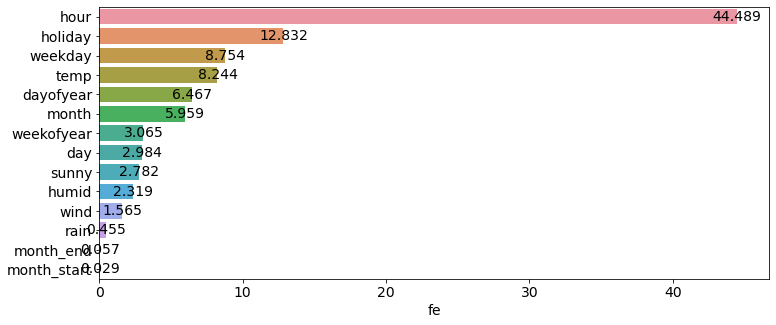

In [72]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 5))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

# 앙상블

In [82]:
rf_preds[0]

8670.350159999996

In [85]:
xgb_preds[0]

8679.39453125

In [86]:
lgbm_preds[0]

8680.808248999447

In [87]:
cat_preds[0]

8656.31945509959

## best_5: 6.43910

In [111]:
best_5_ens_preds = (np.array(rf_preds) + np.array(et_preds) + np.array(xgb_preds) + np.array(lgbm_preds) + np.array(cat_preds))/5

In [113]:
sub.answer = best_5_ens_preds

In [114]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8673.045981
1,1 2020-08-25 01,8661.053488
2,1 2020-08-25 02,8651.861820
3,1 2020-08-25 03,8642.012491
4,1 2020-08-25 04,8630.936301
...,...,...
10075,60 2020-08-31 19,4081.164878
10076,60 2020-08-31 20,3976.703809
10077,60 2020-08-31 21,3813.488085
10078,60 2020-08-31 22,3623.220672


In [115]:
sub.to_csv('submission/210615_best5-ens.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8673.045981
1,1 2020-08-25 01,8661.053488
2,1 2020-08-25 02,8651.861820
3,1 2020-08-25 03,8642.012491
4,1 2020-08-25 04,8630.936301
...,...,...
10075,60 2020-08-31 19,4081.164878
10076,60 2020-08-31 20,3976.703809
10077,60 2020-08-31 21,3813.488085
10078,60 2020-08-31 22,3623.220672


## best_4: 6.30213

In [116]:
best_4_ens_preds = (np.array(rf_preds) + np.array(xgb_preds) + np.array(lgbm_preds) + np.array(cat_preds)) / 4

In [117]:
sub.answer = best_4_ens_preds

In [118]:
sub.to_csv('submission/210616_best4-ens.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8671.813196
1,1 2020-08-25 01,8657.645541
2,1 2020-08-25 02,8647.434135
3,1 2020-08-25 03,8637.774414
4,1 2020-08-25 04,8629.254116
...,...,...
10075,60 2020-08-31 19,4057.952538
10076,60 2020-08-31 20,3966.485161
10077,60 2020-08-31 21,3822.502706
10078,60 2020-08-31 22,3627.019560


## best_3: 	6.23728

In [119]:
best_3_ens_preds = (np.array(rf_preds) + np.array(xgb_preds) + np.array(lgbm_preds)) / 3

In [120]:
sub.answer = best_3_ens_preds

In [121]:
sub.to_csv('submission/210616_best3-ens.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8676.850980
1,1 2020-08-25 01,8663.813031
2,1 2020-08-25 02,8653.743009
3,1 2020-08-25 03,8644.149961
4,1 2020-08-25 04,8636.867325
...,...,...
10075,60 2020-08-31 19,4053.791841
10076,60 2020-08-31 20,3965.412505
10077,60 2020-08-31 21,3814.786227
10078,60 2020-08-31 22,3606.937097


## best_2: 6.27677

In [122]:
best_2_ens_preds = (np.array(xgb_preds) + np.array(lgbm_preds)) / 2

In [123]:
sub.answer = best_2_ens_preds

In [124]:
sub.to_csv('submission/210616_best2-ens.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.101390
1,1 2020-08-25 01,8661.843707
2,1 2020-08-25 02,8647.937473
3,1 2020-08-25 03,8636.907782
4,1 2020-08-25 04,8628.741067
...,...,...
10075,60 2020-08-31 19,4048.274642
10076,60 2020-08-31 20,3940.856678
10077,60 2020-08-31 21,3802.487981
10078,60 2020-08-31 22,3649.908445


# 스택킹CV: 6.52405

1~3 단계를 kfold로 진행합니다.

---------------------
1. train set을 x_train, y_train, x_val, y_val 로 나눕니다. test set 은 x_test 라고 하겠습니다.
2. x_train, y_train 으로 model 을 training 합니다.
3. x_val로 predict 합니다.
---------------
4. pred를 모아서 s_train 을 만듭니다.
5. s_train, y_val 로 model 을 training 합니다.
6. x_test로 predict 합니다.
7. pred 는 최종 결과물입니다.

In [146]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_x_{}'.format(i)] = train.loc[train.num == i, ~train.columns.isin(['target', 'num', 'cooler', 'solar'])]
    
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_y_{}'.format(i)] = train.loc[train.num == i, 'target']
    
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_x_{}'.format(i)] = test.loc[test.num == i, ~test.columns.isin(['num', 'cooler', 'solar'])]

In [147]:
%%time
train_preds = []
test_preds = []
for i in range(1, 61):
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='smape',
                  early_stopping_rounds=30, verbose=0)
        models[fold]=model
    
    pred = models[0].predict(globals()['train_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['train_x_{}'.format(i)]) / 5
    train_preds.append(pred.tolist())
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    test_preds.append(pred.tolist())

Wall time: 3min 4s


In [148]:
lgbm_train_pred = sum(train_preds, [])
lgbm_test_pred = sum(test_preds, [])

In [149]:
%%time
train_preds = []
test_preds = []
for i in range(1, 61): 
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model=XGBRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  eval_metric='rmse',
                  early_stopping_rounds=30, verbose=0)
        models[fold]=model
    
    pred = models[0].predict(globals()['train_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['train_x_{}'.format(i)]) / 5
    train_preds.append(pred.tolist())
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    test_preds.append(pred.tolist())

Wall time: 3min 39s


In [150]:
xgb_train_pred = sum(train_preds, [])
xgb_test_pred = sum(test_preds, [])

In [151]:
%%time
train_preds = []
test_preds = []
for i in range(1, 61):
    rf = RandomForestRegressor(random_state=42, oob_score=True)
    rf.fit(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)])
    pred = rf.predict(globals()['train_x_{}'.format(i)])
    train_preds.append(pred.tolist())
    pred = rf.predict(globals()['test_x_{}'.format(i)])
    test_preds.append(pred.tolist())

Wall time: 40.7 s


In [152]:
rf_train_pred = sum(train_preds, [])
rf_test_pred = sum(test_preds, [])

In [153]:
%%time
train_preds = []
test_preds = []
for i in range(1, 61):
    cross = KFold(n_splits=5, shuffle=True, random_state=42)
    folds = []
    for train_idx, valid_idx in cross.split(globals()['train_x_{}'.format(i)], globals()['train_y_{}'.format(i)]):
        folds.append((train_idx, valid_idx))
        
    models={}
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_tra = globals()['train_x_{}'.format(i)].iloc[train_idx, :]
        y_tra = globals()['train_y_{}'.format(i)].iloc[train_idx]
        X_val = globals()['train_x_{}'.format(i)].iloc[valid_idx, :]
        y_val = globals()['train_y_{}'.format(i)].iloc[valid_idx]

        model = CatBoostRegressor(learning_rate=0.027, random_state=42, n_estimators=10000, eval_metric='SMAPE')
        model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
                  early_stopping_rounds=30, verbose=0)
        models[fold] = model
    
    pred = models[0].predict(globals()['train_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['train_x_{}'.format(i)]) / 5
    train_preds.append(pred.tolist())
    
    pred = models[0].predict(globals()['test_x_{}'.format(i)]) / 5
    for k in range(1, 5):
        pred += models[k].predict(globals()['test_x_{}'.format(i)]) / 5
    test_preds.append(pred.tolist())

Wall time: 12min 42s


In [154]:
cat_train_pred = sum(train_preds, [])
cat_test_pred = sum(test_preds, [])

In [155]:
train_preds_set = {'lgbm': lgbm_train_pred,
                   'xgb': xgb_train_pred,
                   'rf': rf_train_pred,
                   'catb': cat_train_pred}

In [156]:
test_preds_set = {'lgbm': lgbm_test_pred,
                  'xgb': xgb_test_pred,
                  'rf': rf_test_pred,
                  'catb': cat_test_pred}

In [157]:
s_train = pd.DataFrame(train_preds_set)

In [158]:
s_test = pd.DataFrame(test_preds_set)

In [159]:
s_train

,lgbm,xgb,rf,catb
0,8093.300750,8151.597656,8142.32736,8159.172921
1,8055.840071,8106.591797,8124.13152,8124.260286
2,8043.936933,8093.568359,8077.04784,8096.553694
3,8041.707080,8050.730469,8048.45808,8054.554722
4,8038.678075,8040.192383,8035.95816,8040.631210
...,...,...,...,...
122395,4025.076848,4034.629883,4098.38400,4031.991616
122396,3810.161757,3882.434570,3938.91120,3837.501499
122397,3637.138483,3601.465332,3668.94576,3647.025588
122398,3430.163196,3407.400879,3408.98976,3430.311608


In [160]:
s_test

,lgbm,xgb,rf,catb
0,8680.808249,8679.394531,8670.35016,8656.319455
1,8667.287999,8656.399414,8667.75168,8638.357473
2,8653.053657,8642.821289,8665.35408,8627.722406
3,8640.719860,8633.095703,8658.63432,8617.831757
4,8634.266314,8623.215820,8653.11984,8605.996872
...,...,...,...,...
10075,4036.639616,4059.909668,4064.82624,4080.334746
10076,3930.032691,3951.680664,4014.52416,3981.012115
10077,3796.872690,3808.103271,3839.38272,3858.950402
10078,3613.909907,3685.906982,3520.99440,3701.181191


In [163]:
sy_train = train.target

In [164]:
%%time
final_pred = []
cross = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in cross.split(s_train, sy_train):
    folds.append((train_idx, valid_idx))

models={}
for fold in range(5):
    train_idx, valid_idx = folds[fold]
    X_tra = s_train.iloc[train_idx, :]
    y_tra = sy_train.iloc[train_idx]
    X_val = s_train.iloc[valid_idx, :]
    y_val = sy_train.iloc[valid_idx]

    model=LGBMRegressor(learning_rate=0.027, random_state=42, n_estimators=10000)
    model.fit(X_tra, y_tra, eval_set=[(X_tra, y_tra), (X_val, y_val)],
              eval_metric='smape',
              early_stopping_rounds=30, verbose=100)
    models[fold]=model

for k in range(5):
    final_pred.append(models[k].predict(s_test))

Training until validation scores don't improve for 30 rounds
[100]	training's l2: 26329.5	valid_1's l2: 26977.7
[200]	training's l2: 8474.01	valid_1's l2: 9221.21
[300]	training's l2: 8348.25	valid_1's l2: 9131.05
[400]	training's l2: 8319.37	valid_1's l2: 9116.44
[500]	training's l2: 8297.37	valid_1's l2: 9103.77
[600]	training's l2: 8277.72	valid_1's l2: 9093.73
[700]	training's l2: 8261.43	valid_1's l2: 9087.71
[800]	training's l2: 8247.93	valid_1's l2: 9083.84
[900]	training's l2: 8235.54	valid_1's l2: 9081.21
[1000]	training's l2: 8224.38	valid_1's l2: 9078.7
[1100]	training's l2: 8215.67	valid_1's l2: 9076.84
[1200]	training's l2: 8206.66	valid_1's l2: 9075.46
[1300]	training's l2: 8198.82	valid_1's l2: 9074.47
[1400]	training's l2: 8190.96	valid_1's l2: 9073.25
Early stopping, best iteration is:
[1466]	training's l2: 8186.14	valid_1's l2: 9072.5
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 26265.8	valid_1's l2: 27528.7
[200]	training's l2: 83

In [169]:
sub.answer = np.array(final_pred).mean(axis=0)

In [173]:
sub.to_csv('submission/210619_stacking.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8671.524808
1,1 2020-08-25 01,8671.524808
2,1 2020-08-25 02,8671.524808
3,1 2020-08-25 03,8651.098062
4,1 2020-08-25 04,8642.315431
...,...,...
10075,60 2020-08-31 19,4093.726959
10076,60 2020-08-31 20,4002.673619
10077,60 2020-08-31 21,3831.721774
10078,60 2020-08-31 22,3595.948040


In [168]:
sub

,num_date_time,answer
0,1 2020-08-25 00,8680.171248
1,1 2020-08-25 01,8676.320832
2,1 2020-08-25 02,8672.016816
3,1 2020-08-25 03,8665.650864
4,1 2020-08-25 04,8657.605296
...,...,...
10075,60 2020-08-31 19,4091.894496
10076,60 2020-08-31 20,4010.398560
10077,60 2020-08-31 21,3804.887520
10078,60 2020-08-31 22,3587.163840
